# NLP (Natural Language Processing) with Python
* Dealing with text , which basically consists of combining machine learning techniques with text
* Steps: Compile documents , Feautureize them , Features Comparison
* Bag of Words -> A document contain Vectorize count of words ( done by using words of all documents ,check how many time our word occur )
* Similarity of of Documents is measure by using Cos(@) function using bag of words
* coprus is group of all documents
* TDF -> fre of word in document
* IDF -> fre of word in corpus or all documents

## Get the Data
We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [123]:
import nltk

In [124]:
messages = []
for i in open('SMSSpamCollection'):
    messages.append(i.rstrip())
messages[:1]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']

In [125]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [126]:
import pandas as pd

In [127]:
text_df = pd.read_csv('SMSSpamCollection',sep='\t',names=['labels','messages'])

In [128]:
text_df.head()

,labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [129]:
text_df.describe()

,labels,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [130]:
text_df.groupby('labels').count()

,messages
labels,
ham,4825
spam,747


In [131]:
text_df.groupby('labels').describe()

messages                                                               
          count unique                                                top freq
labels                                                                        
ham        4825   4516                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [132]:
text_df['message_length'] = text_df['messages'].apply(len)
text_df.head()

,labels,messages,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


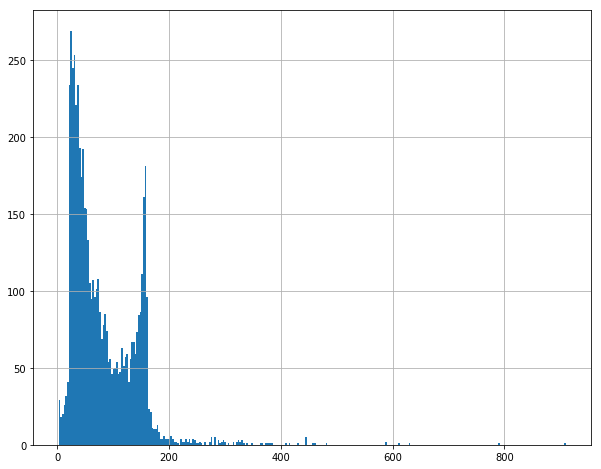

In [133]:
text_df['message_length'].hist(bins=300,figsize=(10,8))

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

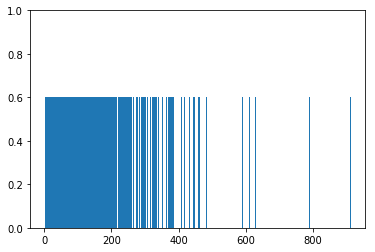

In [135]:
sns.rugplot(text_df['message_length'],height=.6)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A21F73F128>,
      dtype=object)

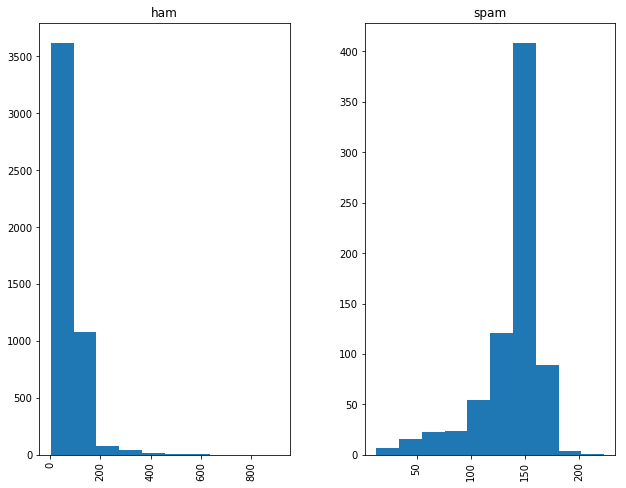

In [136]:
text_df.hist(by='labels',column='message_length',figsize=(10,8))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Text Pre-processing
Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [137]:
import string

In [138]:
mess = 'Sample message! Notice: it has punctuation.'
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [139]:
nopunc = [p for p in mess if p not in string.punctuation]
nopunc = ''.join(nopunc)
nopunc

'Sample message Notice it has punctuation'

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [140]:
from nltk.corpus import stopwords
removestopwords = [stopword for stopword in nopunc.split() if stopword not in stopwords.words('english')]
removestopwords

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [141]:
def cleantext(text):
    p = [c for c in text if c not in string.punctuation]
    p = ''.join(p)
    
    cleantext = [word for word in p.split() if word not in stopwords.words('english')]
    return cleantext

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [142]:
text_df['messages'].head(1).apply(cleantext)

0    [Go, jurong, point, crazy, Available, bugis, n...
Name: messages, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [143]:
from sklearn.feature_extraction.text import CountVectorizer 

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [165]:
bow_tranformer = CountVectorizer(analyzer=cleantext)

In [166]:
bow_tranformer.fit(text_df['messages'])

CountVectorizer(analyzer=<function cleantext at 0x000002A21488CC80>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [167]:
m = text_df['messages'][3]
m

'U dun say so early hor... U c already then say...'

In [168]:
bow = bow_tranformer.transform([m])
print(bow.nnz)
print(bow.shape)

7
(1, 11617)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [169]:
print(bow_tranformer.get_feature_names()[4221])

U


In [170]:
print(bow_tranformer.get_feature_names()[9746])

say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [171]:
messages_bow = bow_tranformer.transform(text_df['messages'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11617)
Amount of Non-Zero occurences:  56024


In [172]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.08655038742205227


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [158]:
from sklearn.feature_extraction.text import TfidfTransformer

In [176]:
tfidftransformer = TfidfTransformer()

In [177]:
tfidftransformer.fit(messages_bow)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [178]:
tfidf4 = tfidftransformer.transform(bow)
print(tfidf4)

  (0, 9746)	0.5385626262927564
  (0, 7378)	0.4389365653379857
  (0, 6414)	0.3187216892949149
  (0, 6396)	0.29953799723697416
  (0, 5453)	0.29729957405868723
  (0, 4821)	0.26619801906087187
  (0, 4221)	0.40832589933384067


In [179]:
print(tfidftransformer.idf_[bow_tranformer.vocabulary_['u']] )

3.2800524267409408


In [181]:
messsage_tfidf = tfidftransformer.transform(messages_bow)

There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

## Training a model
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.
We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [182]:
from sklearn.naive_bayes import MultinomialNB

In [185]:
nb = MultinomialNB()

In [186]:
nb.fit(messsage_tfidf,text_df['labels'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [191]:
p = nb.predict(messsage_tfidf)

In [192]:
print(p)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".
In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [190]:
from sklearn.metrics import classification_report

In [193]:
print(classification_report(text_df['labels'],p))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.84      0.92       747

avg / total       0.98      0.98      0.98      5572



In [194]:
from sklearn.cross_validation import train_test_split

In [213]:
X_train, X_test, y_train, y_test = train_test_split(text_df['messages'],text_df['labels'], test_size=0.3)

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [214]:
from sklearn.pipeline import Pipeline

In [215]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=cleantext)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [216]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function cleantext at 0x000002A21488CC80>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=N...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [217]:
p = pipeline.predict(X_test)

In [218]:
print(classification_report(y_test,p))

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1458
       spam       1.00      0.67      0.80       214

avg / total       0.96      0.96      0.95      1672

